In [1]:
import uproot
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from ALLSKY_energy_function import *
from getS50 import *
from draw_compare_multiply import draw_compare_multiply


In [2]:
precision

{'linear_regression': [0.47784965461445356,
  0.43613882227094297,
  0.4655321413225119,
  0.4980133904459551,
  0.49823454311287213,
  0.4903419480087627,
  0.44188496464879673,
  0.4220238581439934,
  0.42492330974676434,
  0.39277853058058215,
  0.37758815180300964,
  0.36208593262129884,
  0.36969292931518277,
  0.37480996871599287,
  0.42783653184062975,
  0.4793118488223307,
  0.5667600505332224,
  0.6535076937495589,
  0.7722625225480088,
  0.7967682556418021],
 'polynomial_regression': [0.39444083335520713,
  0.4249346116363491,
  0.4652461512531595,
  0.49613772525484984,
  0.49812060493132976,
  0.48622132614229513,
  0.4367768386983213,
  0.4204427417277987,
  0.4330232556417229,
  0.3993442318693121,
  0.37646127655668027,
  0.3547457002151507,
  0.34688039650965596,
  0.32613176985195996,
  0.33306330948108936,
  0.34432097421993135,
  0.31515327655310277,
  0.3186308219771918,
  0.28814862343843767,
  0.2747054327581922],
 'Decision_tree_regression': [0.4204400777275085,


In [2]:
test_size = 0.4
savepath = "./fig/energy_reconstruction/"


In [3]:
file = uproot.open("/home2/chenxu/data/gamma_all.root")


In [4]:
data = file["asresult"].arrays(["nch", "theta", "phi", "sigma", "cx", "cy", "sumpf",
                               "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"], library="np")


In [5]:
data["cr"] = np.sqrt(data["cx"]**2+data["cy"]**2)


In [6]:
nch = data["nch"]
theta = data["theta"]
phi = data["phi"]
sigma = data["sigma"]
cx = data["cx"]
cy = data["cy"]
cr = data["cr"]
sumpf = data["sumpf"]
summd = data["summd"]
mr1 = data["mr1"]
ne = data["ne"]
age = data["age"]
pritheta = np.rad2deg(data["pritheta"])
priphi = data["priphi"]
prie = data["prie"]
inout = data["inout"]
simga=data["sigma"]
S50 = getS50(ne, age)


In [7]:
priphi = 180-np.rad2deg(priphi)
priphi[priphi>180] = priphi[priphi>180]-360

In [8]:
cuted = np.where((theta < 60)& (
    inout == 1) & (age > 0.31) &(age<1.59)&(sigma<1.))


In [9]:
nch = nch[cuted]
theta = theta[cuted]
phi = phi[cuted]
sigma = sigma[cuted]
cx = cx[cuted]
cy = cy[cuted]
sumpf = sumpf[cuted]
summd = summd[cuted]
mr1 = mr1[cuted]
ne = ne[cuted]
age = age[cuted]
pritheta = pritheta[cuted]
priphi = priphi[cuted]
prie = prie[cuted]/1000
inout = inout[cuted]
S50 = S50[cuted]
sectheta = 1/np.cos(np.deg2rad(theta))


In [10]:
train_index, test_index = train_test_split(
    range(nch.shape[0]), test_size=test_size, shuffle=True, random_state=42)


In [11]:
nch_train = nch[train_index]
theta_train = theta[train_index]
phi_train = phi[train_index]
sigma_train = sigma[train_index]
cx_train = cx[train_index]
cy_train = cy[train_index]
sumpf_train = sumpf[train_index]
summd_train = summd[train_index]
mr1_train = mr1[train_index]
ne_train = ne[train_index]
age_train = age[train_index]
pritheta_train = pritheta[train_index]
priphi_train = priphi[train_index]
prie_train = prie[train_index]
inout_train = inout[train_index]
S50_train = S50[train_index]
sectheta_train = sectheta[train_index]

nch_test = nch[test_index]
theta_test = theta[test_index]
phi_test = phi[test_index]
sigma_test = sigma[test_index]
cx_test = cx[test_index]
cy_test = cy[test_index]
sumpf_test = sumpf[test_index]
summd_test = summd[test_index]
mr1_test = mr1[test_index]
ne_test = ne[test_index]
age_test = age[test_index]
pritheta_test = pritheta[test_index]
priphi_test = priphi[test_index]
prie_test = prie[test_index]
inout_test = inout[test_index]
S50_test = S50[test_index]
sectheta_test = sectheta[test_index]


# 线性回归

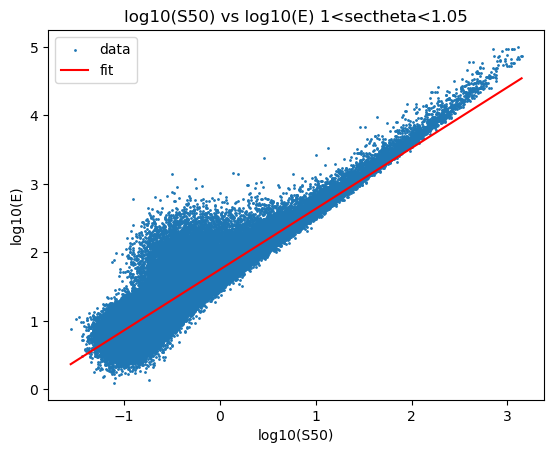

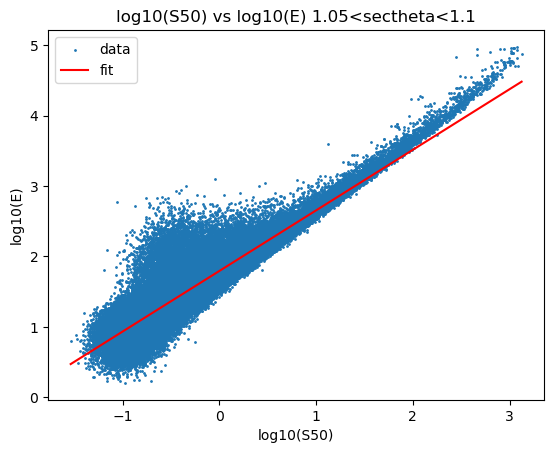

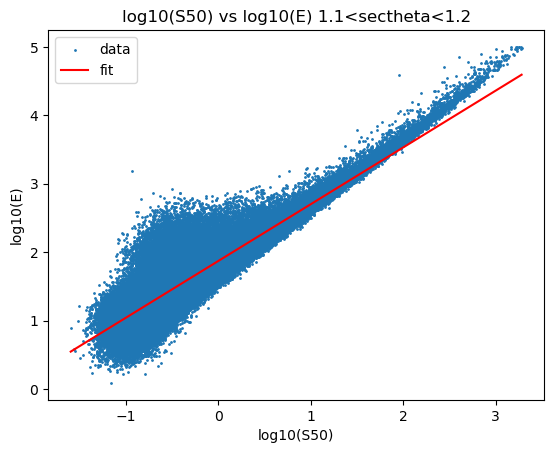

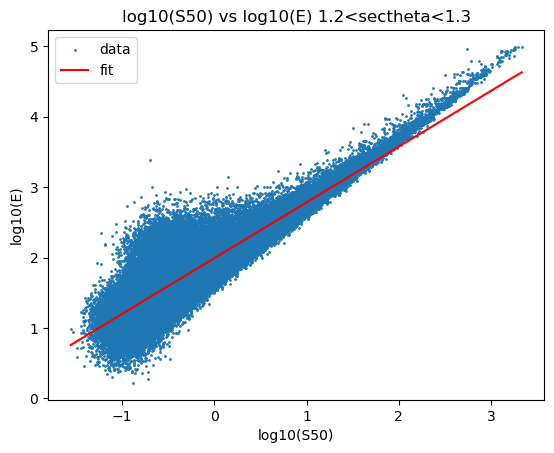

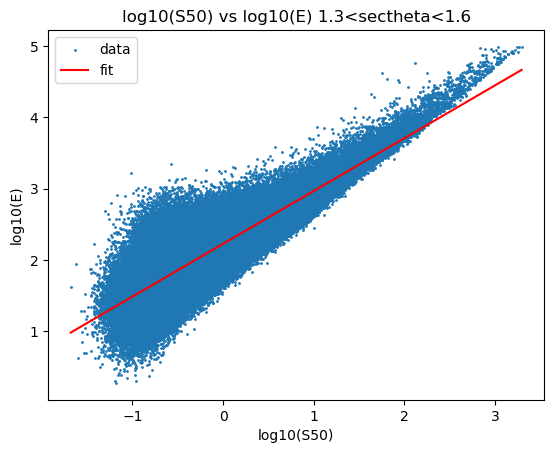

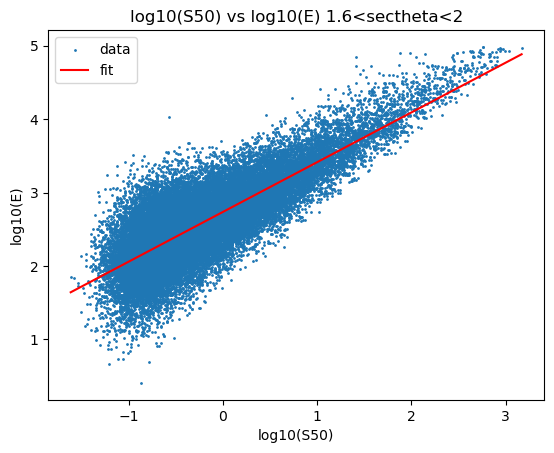

In [12]:
method = "linear_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
sectheta_min = [1, 1.05, 1.1, 1.2, 1.3, 1.6]
sectheta_max = [1.05, 1.1, 1.2, 1.3, 1.6, 2]
energy_pred = np.zeros_like(prie_test.reshape(-1, 1))
for i in range(len(sectheta_min)):
    tmpcut_train = np.where((sectheta_train > sectheta_min[i]) & (
        sectheta_train < sectheta_max[i]))
    tmpcut_test = np.where((sectheta_test > sectheta_min[i]) & (
        sectheta_test < sectheta_max[i]))
    X = np.log10(S50_train[tmpcut_train]).reshape(-1, 1)
    y = np.log10(prie_train[tmpcut_train]).reshape(-1, 1)

    # 创建线性回归模型
    model = LinearRegression()
    model.fit(X, y)

    plt.scatter(X.reshape(-1), y.reshape(-1), label="data", s=1)
    x_plot = np.linspace(np.min(X), np.max(X), 2).reshape(-1, 1)
    plt.plot(x_plot, model.predict(x_plot), color="red", label="fit")
    plt.xlabel("log10(S50)")
    plt.ylabel("log10(E)")
    plt.title("log10(S50) vs log10(E) " +
              f"{sectheta_min[i]}<sectheta<{sectheta_max[i]}")
    plt.legend()
    mkdir(tmpsavepath)
    plt.savefig(
        f"{tmpsavepath}/S50_E_{sectheta_min[i]}<sectheta<{sectheta_max[i]}.png")
    plt.show()

    X_test = np.log10(S50_test[tmpcut_test]).reshape(-1, 1)

    energy_pred[tmpcut_test] = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)


<Figure size 640x480 with 0 Axes>

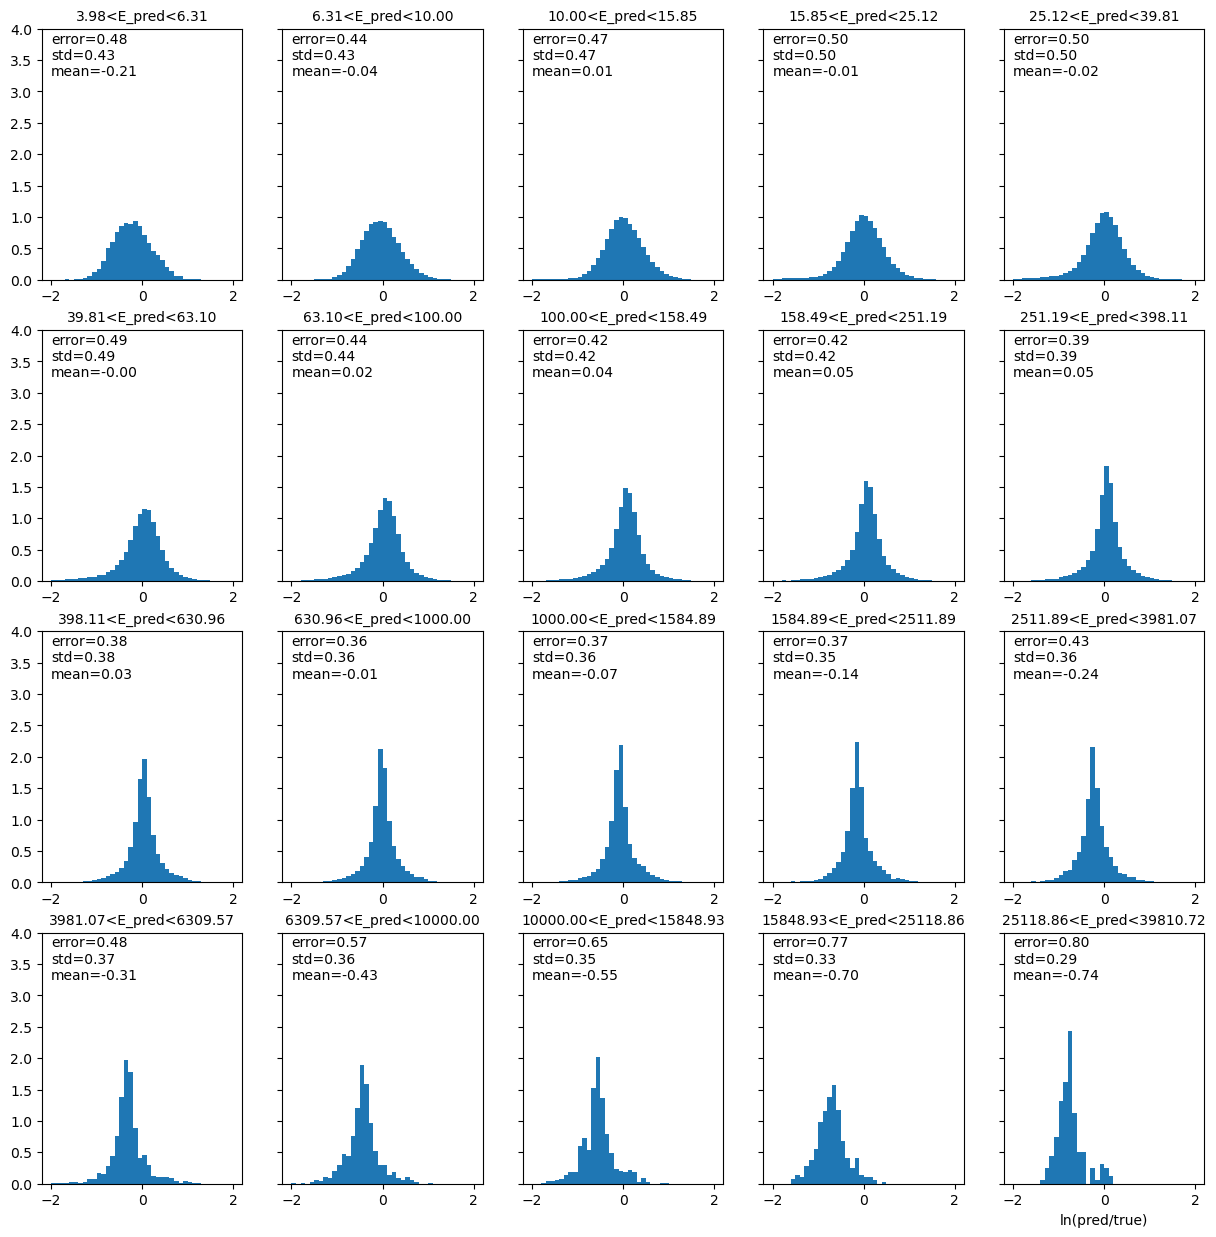

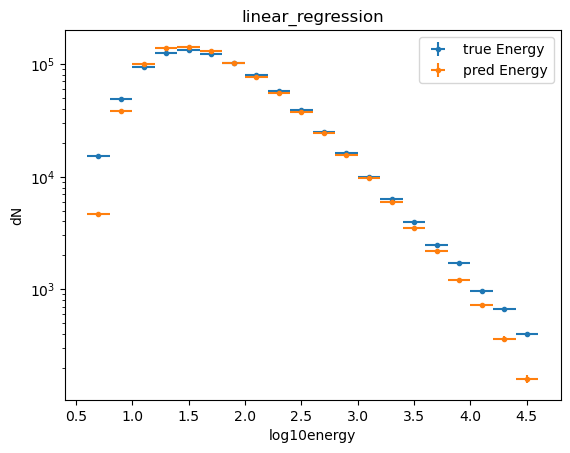

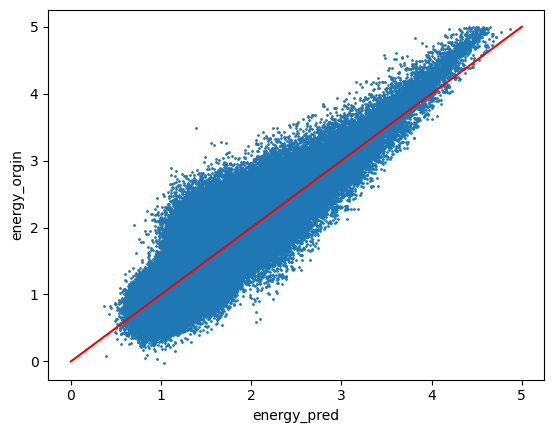

In [13]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

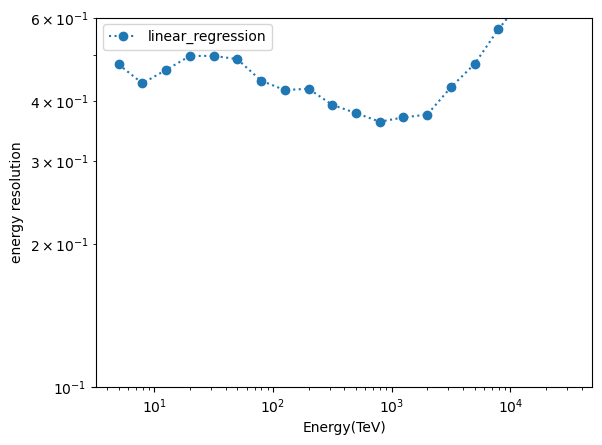

In [14]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)

# 多项式回归

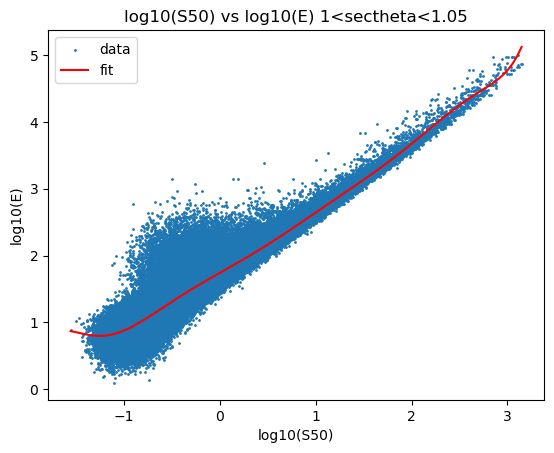

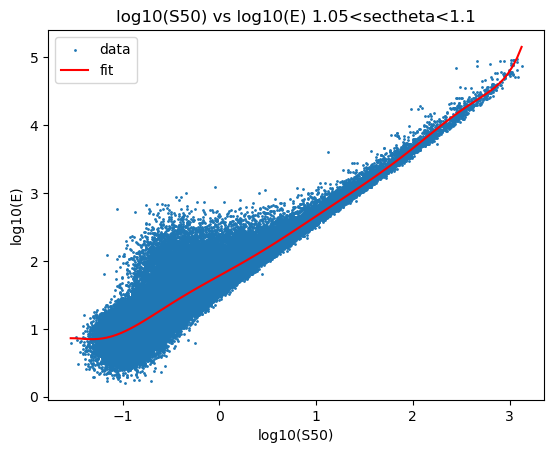

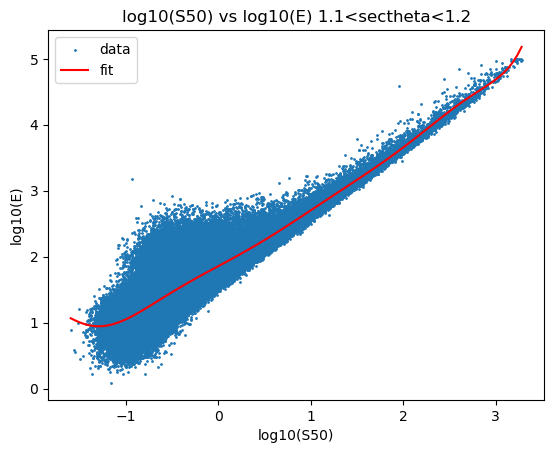

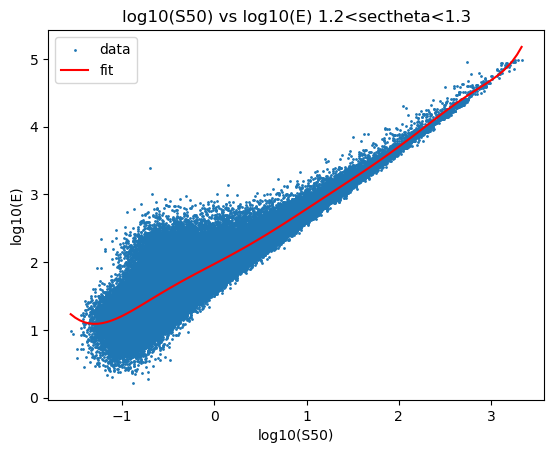

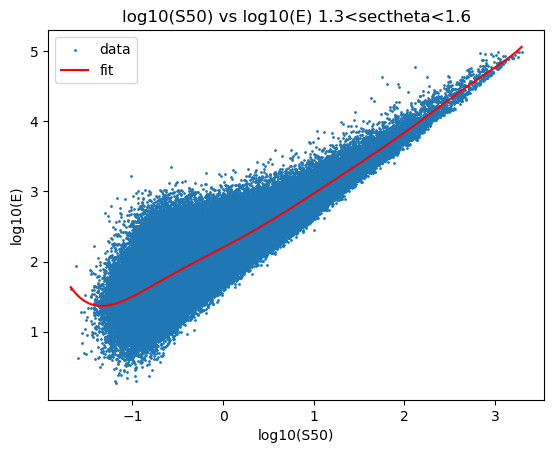

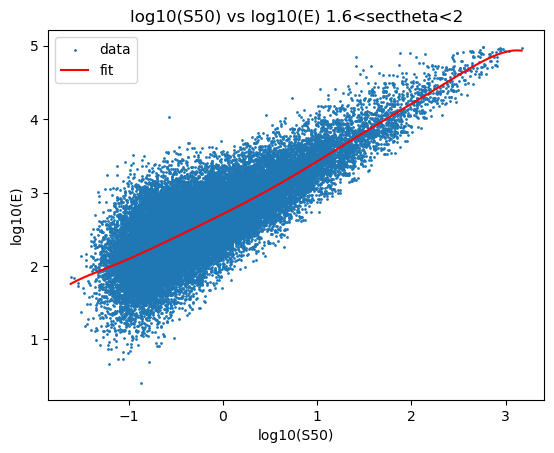

In [15]:
method = "polynomial_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)

sectheta_min = [1, 1.05, 1.1, 1.2, 1.3, 1.6]
sectheta_max = [1.05, 1.1, 1.2, 1.3, 1.6, 2]
score_max = -2
best_degree = 0
energy_pred = np.zeros_like(prie_test.reshape(-1, 1))
for i in range(len(sectheta_min)):
    tmpcut_train = np.where((sectheta_train > sectheta_min[i]) & (
        sectheta_train < sectheta_max[i]))
    tmpcut_test = np.where((sectheta_test > sectheta_min[i]) & (
        sectheta_test < sectheta_max[i]))
    X = np.log10(S50_train[tmpcut_train]).reshape(-1, 1)
    y = np.log10(prie_train[tmpcut_train]).reshape(-1, 1)
    for degree in range(1, 10):
        poly = PolynomialFeatures(degree=degree)
        X_withdegree = poly.fit_transform(X)
        # 创建线性回归模型
        model = LinearRegression()
        scores = cross_val_score(
            model, X_withdegree, y, cv=5, scoring='neg_mean_squared_error')
        # print(i, degree, scores.mean(), scores.std())

        if score_max < scores.mean():
            score_max = scores.mean()
            best_degree = degree
    poly = PolynomialFeatures(degree=best_degree)
    X_fit = poly.fit_transform(X)
    model.fit(X_fit, y)

    plt.scatter(X.reshape(-1), y.reshape(-1), label="data", s=1)
    x_plot = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    x_plot_fit = poly.fit_transform(x_plot)
    plt.plot(x_plot, model.predict(x_plot_fit), color="red", label="fit")
    plt.xlabel("log10(S50)")
    plt.ylabel("log10(E)")
    plt.title("log10(S50) vs log10(E) " +
              f"{sectheta_min[i]}<sectheta<{sectheta_max[i]}")
    plt.legend()
    mkdir(tmpsavepath)
    plt.savefig(
        f"{tmpsavepath}/S50_E_{sectheta_min[i]}<sectheta<{sectheta_max[i]}.png")
    plt.show()

    X_test = np.log10(S50_test[tmpcut_test]).reshape(-1, 1)
    X_test = poly.fit_transform(X_test)
    energy_pred[tmpcut_test] = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)


<Figure size 640x480 with 0 Axes>

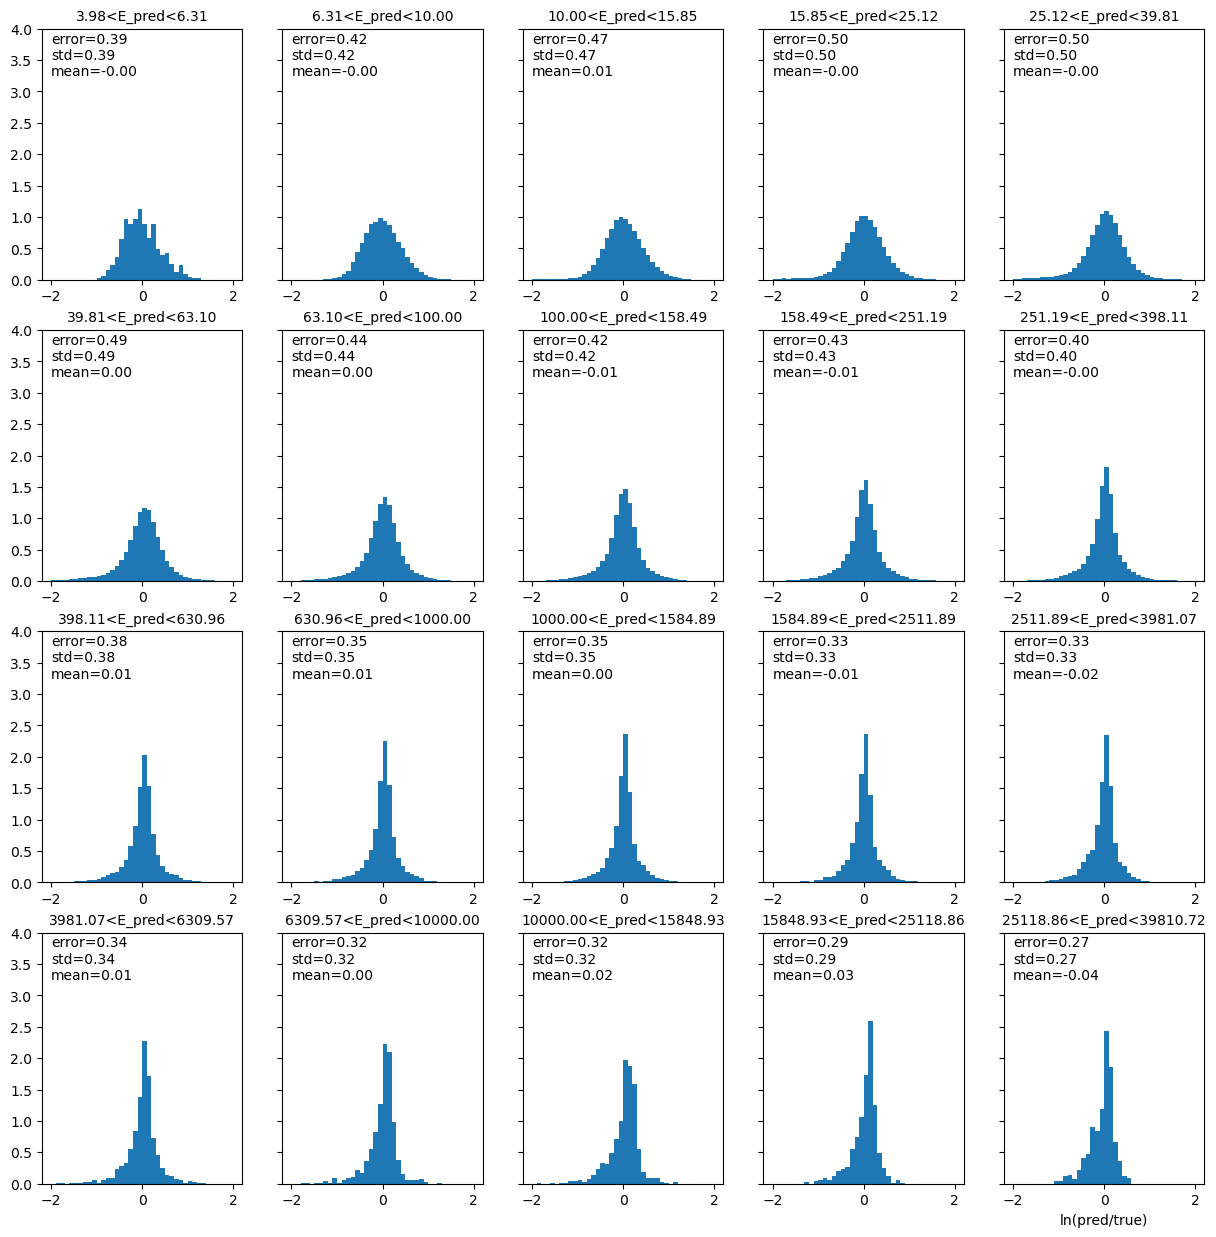

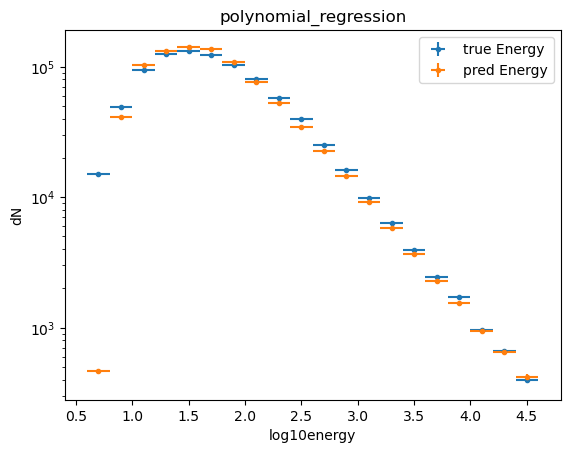

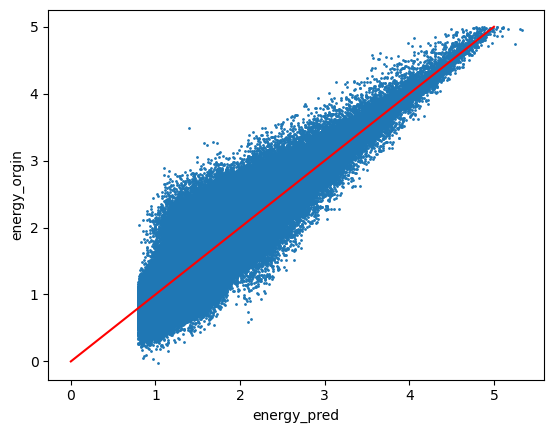

In [16]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

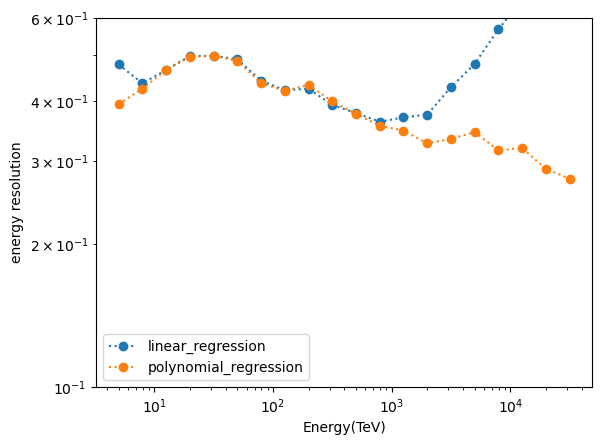

In [17]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)

# 决策树

In [23]:
method = "Decision_tree_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train,
    sigma_train,
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)
for maxdepth in range(8, 15):
    # 创建决策树模型
    regr = DecisionTreeRegressor(max_depth=maxdepth)

    # 进行3则交叉验证，指定评分标准为R^2，并返回数组形式的分数
    scores = cross_val_score(
        regr, X, y, cv=5, scoring='neg_mean_squared_error')

    # 计算交叉验证的平均分数和标准差
    mean_score = scores.mean()
    std_score = scores.std()
    if scoremax < mean_score:
        scoremax = mean_score
        bestmaxdepth = maxdepth
    print(maxdepth, mean_score, std_score)
print(scoremax, bestmaxdepth)

8 -0.030864316305202293 9.335236870898452e-05
9 -0.029344298972126166 8.337484264175854e-05
10 -0.02819382417769508 7.680662649064683e-05
11 -0.027535357647258916 6.804766515148595e-05
12 -0.027255181123722532 8.14730587090711e-05
13 -0.02732072335803885 8.817613722649182e-05
14 -0.02781553318139854 8.519371123528918e-05
-0.027255181123722532 12


In [24]:
model = DecisionTreeRegressor(max_depth=bestmaxdepth)
model.fit(X, y)
X_test = np.array([
    S50_test,
    sectheta_test,
    nch_test,
    sumpf_test,
    summd_test,
    mr1_test,
    ne_test,
    age_test,
    cx_test,
    cy_test,
    sigma_test,
]).T
X_test = sc.transform(X_test)
energy_pred = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)

<Figure size 640x480 with 0 Axes>

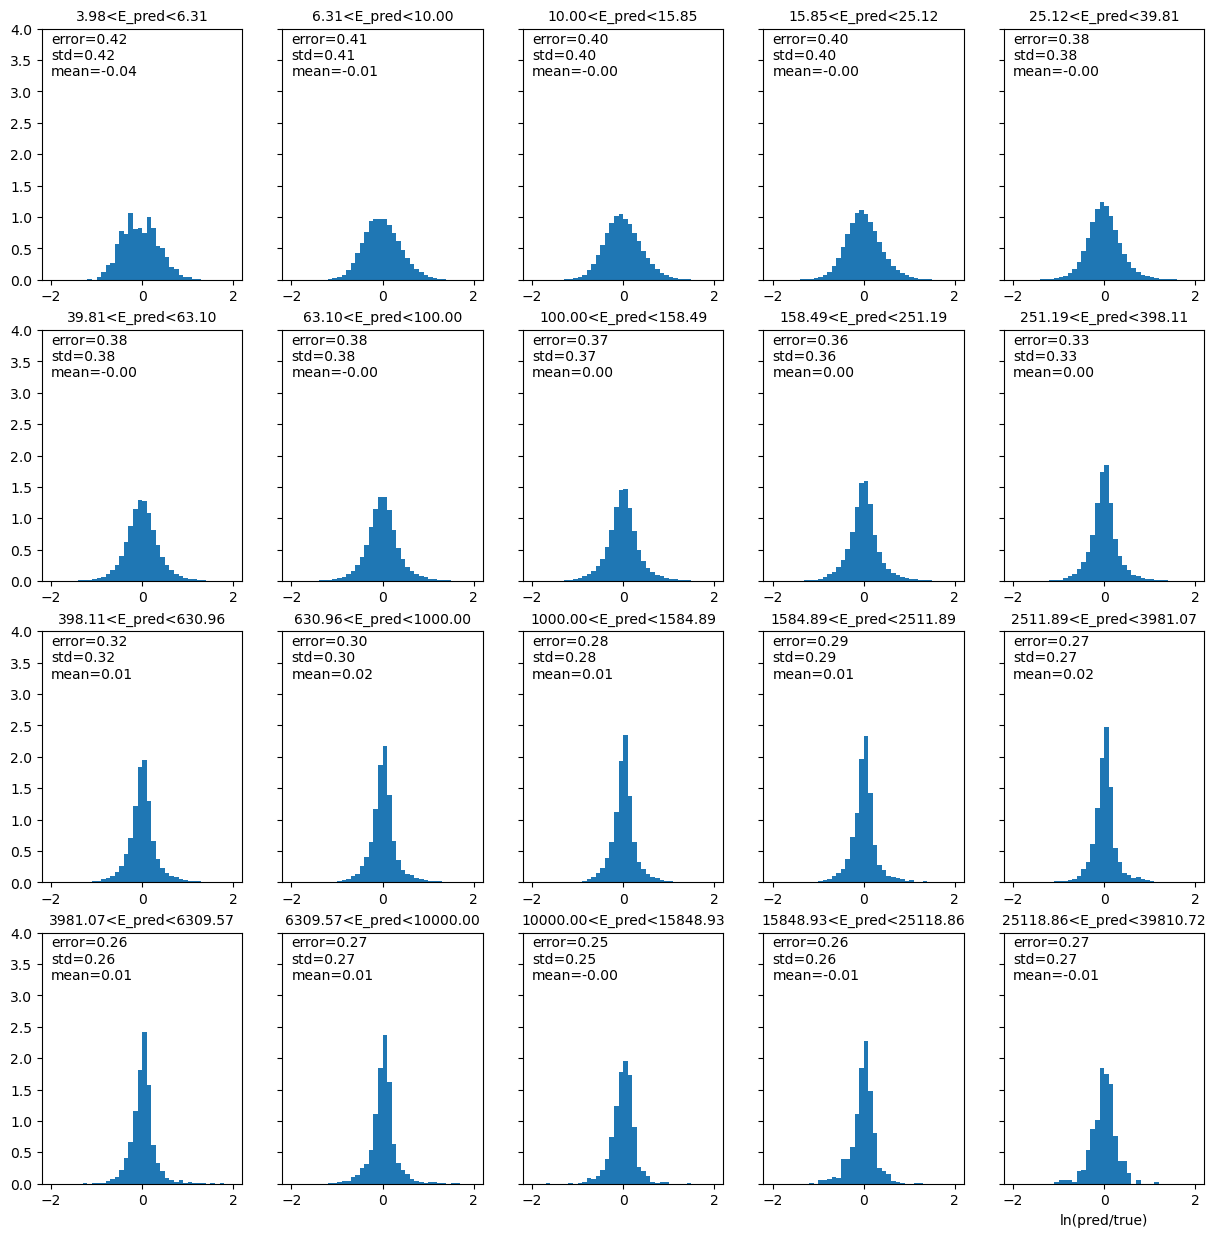

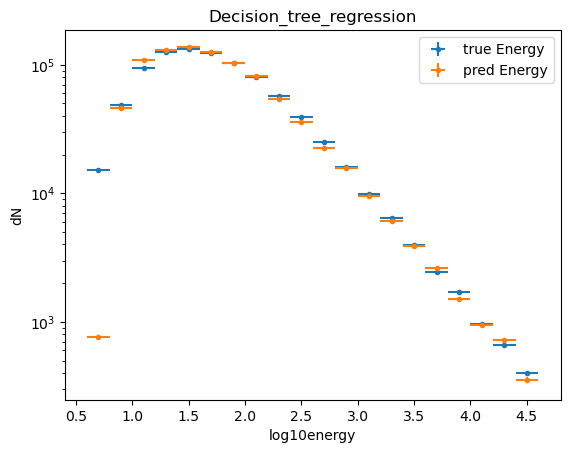

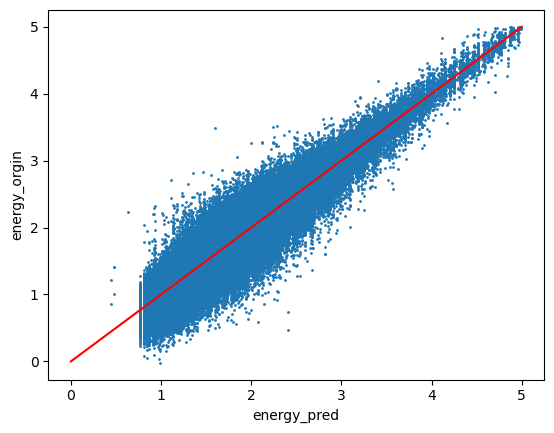

In [25]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

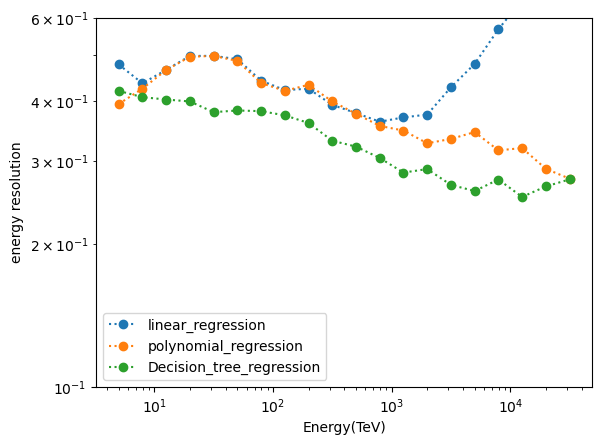

In [26]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)

# 随机森林

In [37]:
method = "Random_Forest_regression"
tmpsavepath = os.path.join(savepath, method)
mkdir(tmpsavepath)
scoremax = -2
sc = PowerTransformer()
x = np.array([
    S50_train,
    sectheta_train,
    nch_train,
    sumpf_train,
    summd_train,
    mr1_train,
    ne_train,
    age_train,
    cx_train,
    cy_train,
    sigma_train,
]).T
y = np.log10(prie_train)

X = sc.fit_transform(x)

model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
X_test = np.array([
    S50_test,
    sectheta_test,
    nch_test,
    sumpf_test,
    summd_test,
    mr1_test,
    ne_test,
    age_test,
    cx_test,
    cy_test,
    sigma_test,
]).T
X_test = sc.transform(X_test)
energy_pred = model.predict(X_test)
energy_orgin = prie_test.reshape(-1)
energy_pred = 10**energy_pred.reshape(-1)

<Figure size 640x480 with 0 Axes>

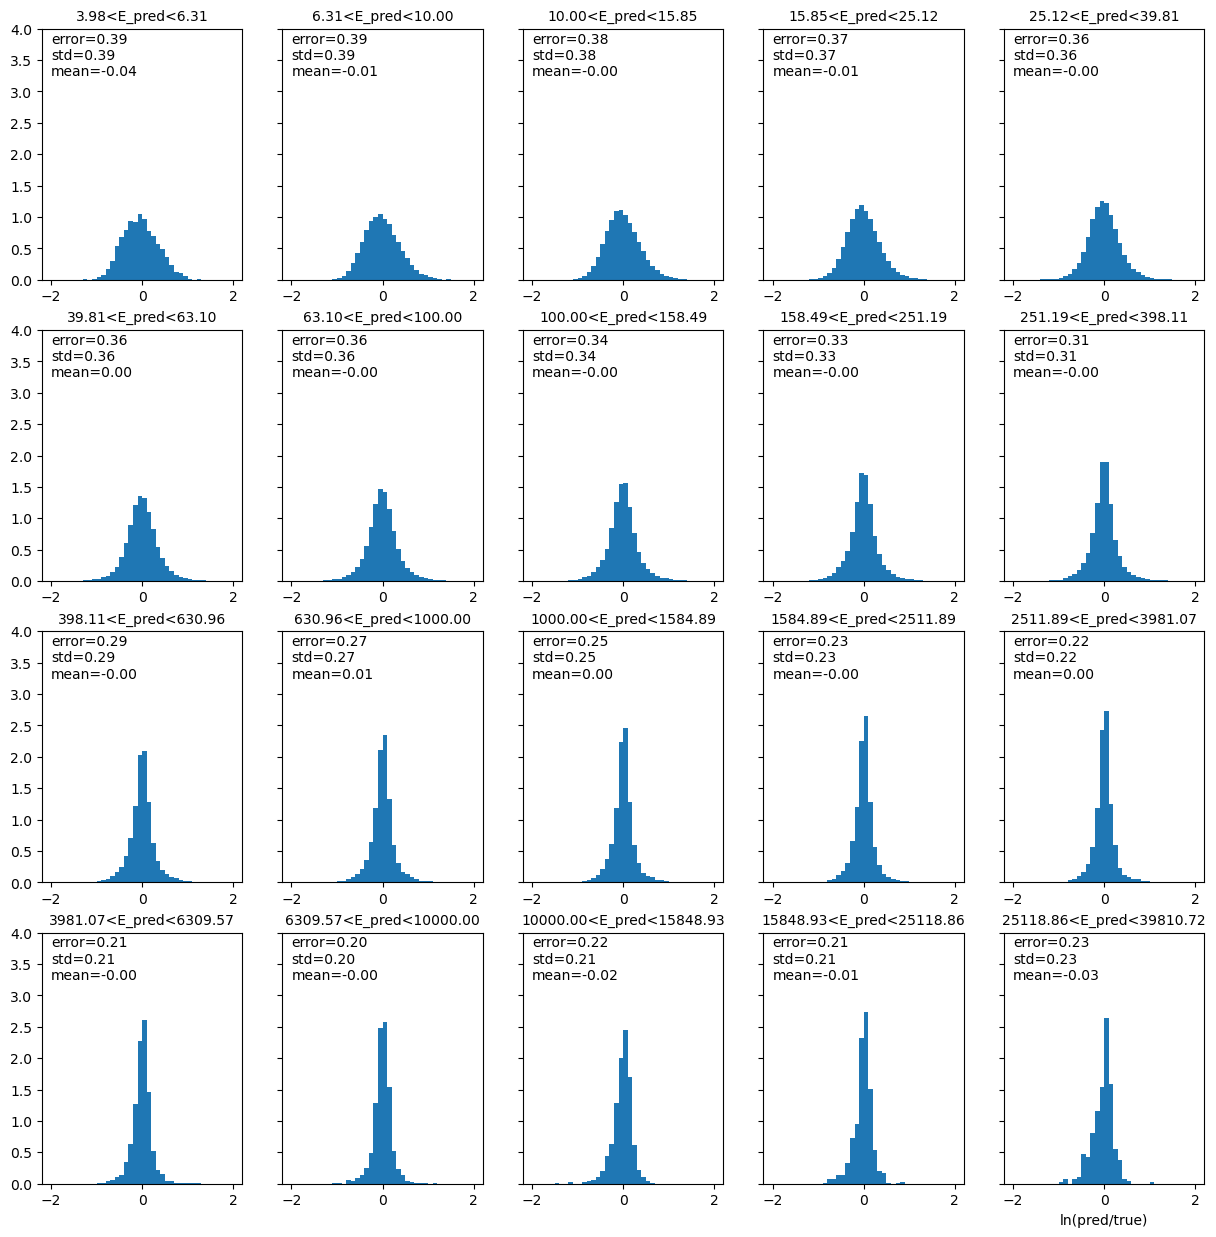

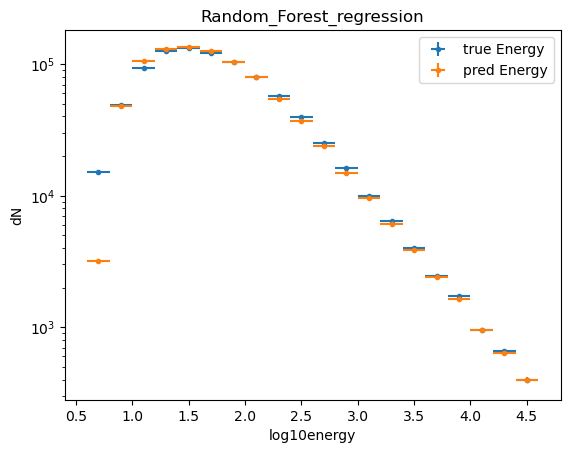

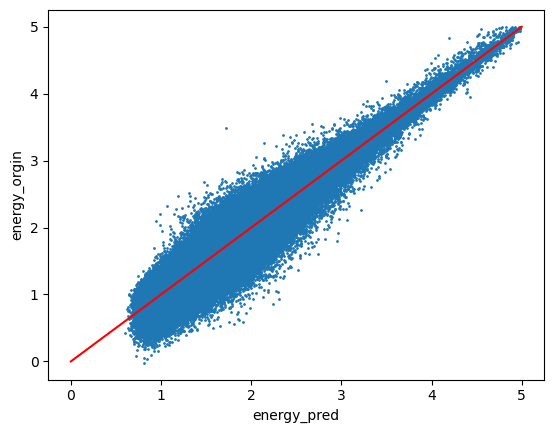

In [38]:
check_fit(energy_pred, energy_orgin, method, tmpsavepath)

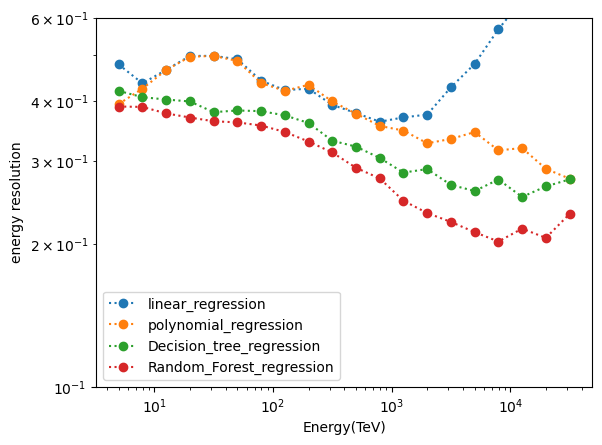

In [39]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)

# autogluon

In [8]:
from autogluon.tabular import TabularDataset, TabularPredictor
predictor = TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/ag-20230327_173915")

In [9]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -0.147451    7528.977551  23830.999727                0.017433          12.843076            3      False         22
1          ExtraTreesMSE_BAG_L2  -0.147589    6944.592044  15685.512442               39.565693          98.140263            2      False         17
2        NeuralNetFastAI_BAG_L2  -0.147605    6949.325627  21718.276954               44.299275        6130.904774            2      False         18
3          LightGBMLarge_BAG_L2  -0.147685    6925.742640  15811.422069               20.716288         224.049889            2      False         21
4               LightGBM_BAG_L2  -0.147697    6927.627165  15788.908210               22.600813         201.536031            2      False         14
5                XGBoost_BAG_L2  -0.14

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


In [10]:
test_data_autogluon = TabularDataset(
    "/home2/hky/github/Gamma_Energy/AllSky/MC_test_AllSky_Data_transformed.csv")
energy_pred = 10**predictor.predict(test_data_autogluon.drop(
    columns=["log_energy"])).to_numpy()

/home2/hky/miniconda3/envs/d2l/lib/python3.9/site-packages/catboost/core.py:1222: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight,


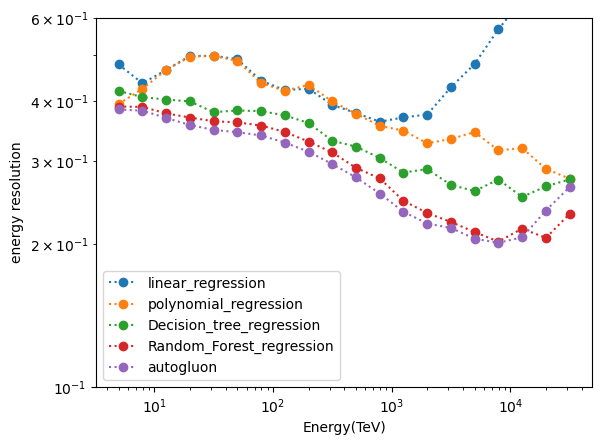

In [3]:
draw_precision()
np.save("precision_ALLSKY_sigma<1.npy", precision)